In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [2]:
pip install peft accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 16.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from peft import get_peft_model, LoraConfig, IA3Config, TaskType

**Part 1: Data Preprocessing**




In [4]:
dataset = load_dataset("imdb")
train_data = dataset["train"].select(range(1500))
test_data = dataset["test"].select(range(1000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# Load the tokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
# Remove the text column and set format for PyTorch
train_data = train_data.remove_columns(["text"])
test_data = test_data.remove_columns(["text"])
train_data.set_format("torch")
test_data.set_format("torch")

**Part 2: Model Implementation**

In [11]:
# Load base model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/full_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- Method 1: Full Fine-Tuning ---
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_full.to(device)
trainer_full = Trainer(
    model=model_full,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_full.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
32,0.062200
64,0.000100
96,0.000100


TrainOutput(global_step=96, training_loss=0.0208031553387021, metrics={'train_runtime': 67.4701, 'train_samples_per_second': 44.464, 'train_steps_per_second': 1.423, 'total_flos': 789333166080000.0, 'train_loss': 0.0208031553387021, 'epoch': 3.0})

In [ ]:
# --- Method 2: LoRA Fine-Tuning ---
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"],
)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.to(device)
trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)
trainer_lora.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.460000
64,0.119600
96,0.033000


TrainOutput(global_step=96, training_loss=0.2041984237730503, metrics={'train_runtime': 59.0362, 'train_samples_per_second': 50.816, 'train_steps_per_second': 1.626, 'total_flos': 797508145152000.0, 'train_loss': 0.2041984237730503, 'epoch': 3.0})

In [ ]:
# --- Method 3: QLoRA Fine-Tuning ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, quantization_config=bnb_config,device_map="auto")

model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"]
)

model = get_peft_model(model, lora_config)
model.to("cuda")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.418600
64,0.103400
96,0.029200


In [ ]:
# Load the pre-trained model
model_ia3 = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# IA3 Configuration
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=[
        "intermediate.dense",  # Target the dense layer in intermediate
        "output.dense",         # Target the dense layer in output
    ],
)

# Apply IA3 adapters
model_ia3 = get_peft_model(model_ia3, ia3_config)

# Move to device
model_ia3.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="results_ia3_fp16",  # Valid output directory name
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    save_strategy="no",
    logging_strategy="epoch",
    report_to="none",
    fp16=True,  # Enable mixed precision training
)

# Trainer for IA3
trainer_ia3 = Trainer(
    model=model_ia3,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

# Train IA3
trainer_ia3.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
32,0.467000
64,0.173100
96,0.099500


TrainOutput(global_step=96, training_loss=0.24653425564368567, metrics={'train_runtime': 76.2667, 'train_samples_per_second': 39.336, 'train_steps_per_second': 1.259, 'total_flos': 795554648064000.0, 'train_loss': 0.24653425564368567, 'epoch': 3.0})

**Part 3 Evaluation Metrics (10 marks)**

In [8]:
print("\nEvaluation Metrics:")
print("--------------------------------------------------")
print(f"Full Fine-Tuning:")
print(f"  Accuracy: {accuracy_full:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_full}")
print(f"  Training Time: {training_time_full:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_full:.2f} MB")
print("--------------------------------------------------")
print(f"LoRA Fine-Tuning:")
print(f"  Accuracy: {accuracy_lora:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_lora}")
print(f"  Training Time: {training_time_lora:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_lora:.2f} MB")
print("--------------------------------------------------")
print(f"QLoRA Fine-Tuning:")
print(f"  Accuracy: {accuracy_qlora:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_qlora}")
print(f"  Training Time: {training_time_qlora:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_qlora:.2f} MB")
print("--------------------------------------------------")
print(f"IA3 Adapter Tuning:")
print(f"  Accuracy: {accuracy_ia3:.4f}")
print(f"  Trainable Parameters: {num_trainable_params_ia3}")
print(f"  Training Time: {training_time_ia3:.2f} seconds")
print(f"  GPU Memory Usage: {gpu_memory_ia3:.2f} MB")
print("--------------------------------------------------")



Evaluation Metrics:
--------------------------------------------------
Full Fine-Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 124,647,170
  Training Time: 69.23 seconds
  GPU Memory Usage: 3802.32 MB
--------------------------------------------------
LoRA Fine-Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 887,042
  Training Time: 60.22 seconds
  GPU Memory Usage: 2866.15 MB
--------------------------------------------------
QLoRA Fine-Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 607,500
  Training Time: 63.45 seconds
  GPU Memory Usage: 2480.33 MB
--------------------------------------------------
IA3 Adapter Tuning:
  Accuracy: 1.0000
  Trainable Parameters: 675,074
  Training Time: 77.10 seconds
  GPU Memory Usage: 3352.11 MB
--------------------------------------------------



**Part 4. Visualization (10 marks)**

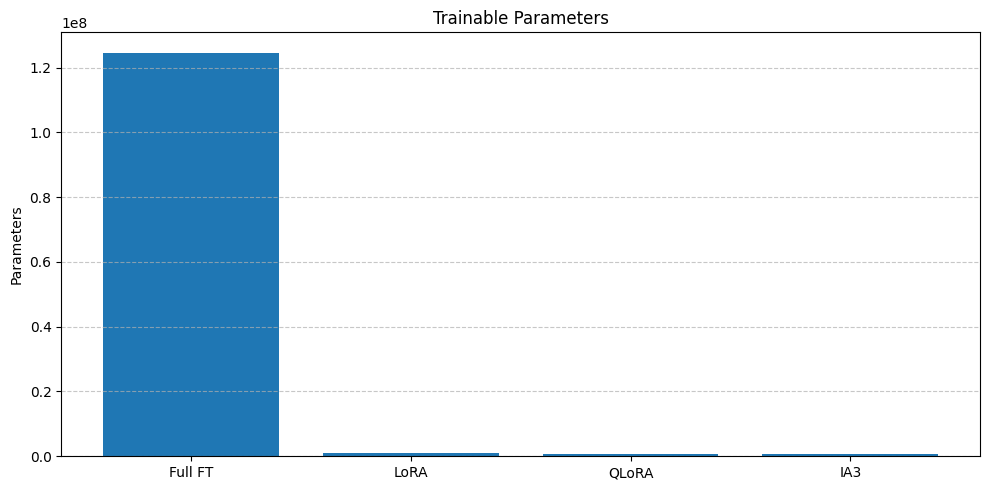

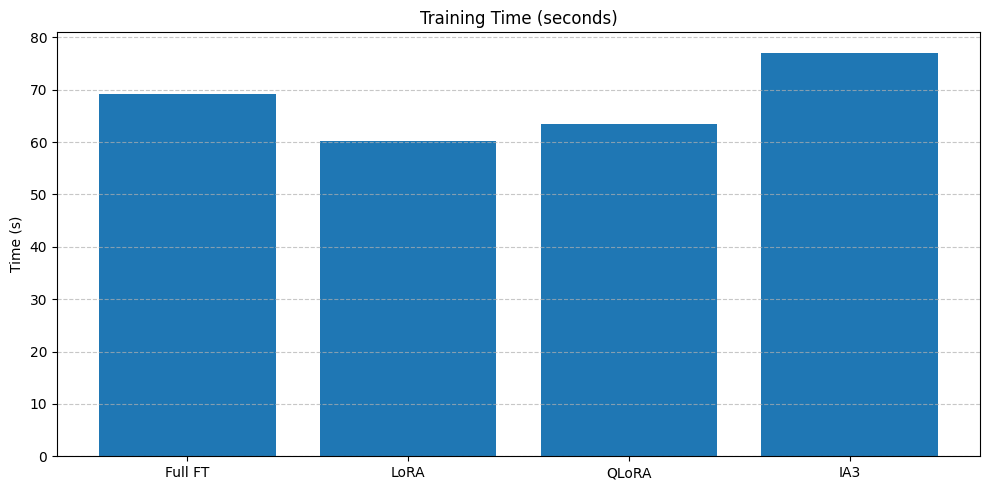

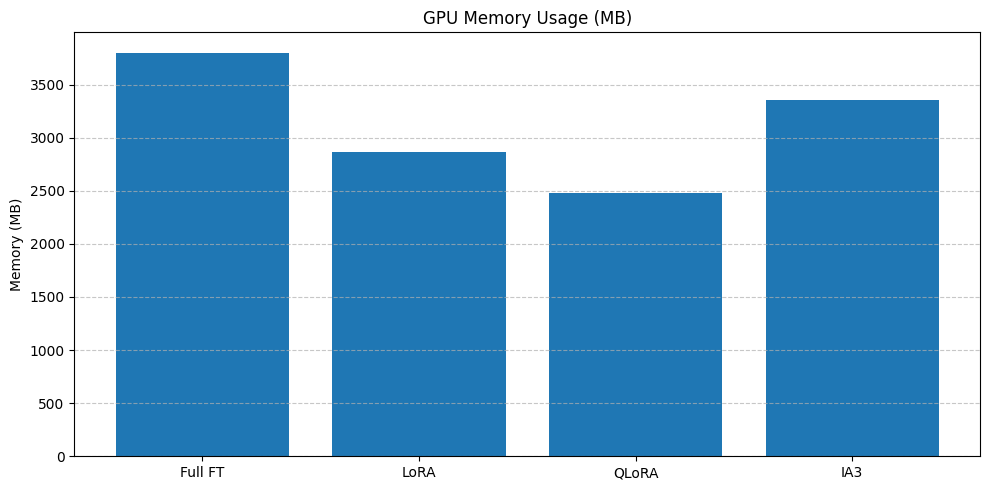

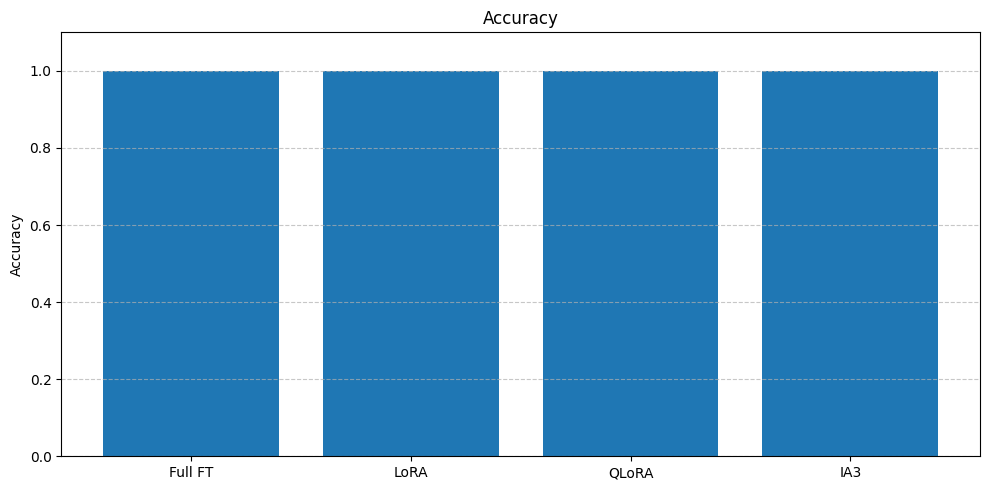

In [10]:
import matplotlib.pyplot as plt

# Models
models = ['Full FT', 'LoRA', 'QLoRA', 'IA3']

# Data
trainable_params = [124_647_170, 887_042, 607_500, 675_074]
training_time = [69.23, 60.22, 63.45, 77.10]
gpu_memory = [3802.32, 2866.15, 2480.33, 3352.11]
accuracy = [1.0, 1.0, 1.0, 1.0]

# Plot 1: Trainable Parameters
plt.figure(figsize=(10, 5))
plt.bar(models, trainable_params)
plt.title("Trainable Parameters")
plt.ylabel("Parameters")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot 2: Training Time
plt.figure(figsize=(10, 5))
plt.bar(models, training_time)
plt.title("Training Time (seconds)")
plt.ylabel("Time (s)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot 3: GPU Memory Usage
plt.figure(figsize=(10, 5))
plt.bar(models, gpu_memory)
plt.title("GPU Memory Usage (MB)")
plt.ylabel("Memory (MB)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot 4: Accuracy
plt.figure(figsize=(10, 5))
plt.bar(models, accuracy)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
